# Weighted metric

In [17]:
from typing import Iterable, List

import numpy as np
import pandas as pd


def weighted_metric(mal_acc: List[float], benign_acc: float) -> float:
    """
    benign_acc: accuracy of benign class
    mal_acc: list of `s` accuracies
    0.5 * benign_acc + 0.5 * (1/(1+2+...+s)) * (s*mal_acc_1 + (s-1)*mal_acc_2 + ... + 1*mal_acc_s)
    """
    s = len(mal_acc)
    weights = list(range(s, 0, -1))

    mal_weighted_avg = np.average(mal_acc, weights=weights)

    weighted_avg = np.average([benign_acc, mal_weighted_avg], weights=[0.5, 0.5])

    return weighted_avg

def unweighted_metric(mal_acc: List[float], benign_acc: float) -> float:
    mal_avg = np.average(mal_acc)
    unweighted_avg = np.average([benign_acc, mal_avg])

    return unweighted_avg

def calc_metrics(df):
    benign_acc_centroid = df[df['lsb']==0]['test_acc_centroid'].iloc[0]
    benign_acc_nn = df[df['lsb']==0]['test_acc_nn'].iloc[0]

    df_mal = df[~(df['lsb'] == 0)].sort_values(by='lsb', ascending=True)

    mal_acc_centroid = df_mal['test_acc_centroid'].tolist()
    mal_acc_nn = df_mal['test_acc_nn'].tolist()

    unweighted_metric_centroid = unweighted_metric(mal_acc_centroid, benign_acc_centroid)
    unweighted_metric_nn = unweighted_metric(mal_acc_nn, benign_acc_nn)

    weighted_metric_centroid = weighted_metric(mal_acc_centroid, benign_acc_centroid)
    weighted_metric_nn = weighted_metric(mal_acc_nn, benign_acc_nn)

    metrics_dict = {
        'unweighted_metric_centroid': unweighted_metric_centroid,
        'unweighted_metric_nn': unweighted_metric_nn,
        'weighted_metric_centroid': weighted_metric_centroid,
        'weighted_metric_nn': weighted_metric_nn
    }

    return pd.Series(metrics_dict)

In [10]:
from typing import Literal
import pandas as pd

from model_xray.configs.enums import *

from model_xray.utils.script_utils import get_siamese_results_dataframe

mc_name:Literal['famous_le_10m', 'famous_le_100m']="famous_le_10m"
imtype:ImageType=ImageType.GRAYSCALE_FOURPART
imsize:int=256
mode:Literal['st', 'es', 'ub', 'none']='ub'

model_arch: Literal['osl_siamese_cnn', 'srnet'] = 'osl_siamese_cnn'
embed_payload_type: PayloadType = PayloadType.BINARY_FILE


df = get_siamese_results_dataframe(
    mc_name=mc_name,
    imtype=imtype,
    imsize=imsize,
    mode=mode,
    model_arch=model_arch,
    embed_payload_type=embed_payload_type
)

df.head()

,run num,mc,lsb,test_acc_centroid,test_acc_nn,model_lsb,model_arch
0,0,famous_le_10m,0,0.6,0.4,1,srnet
1,0,famous_le_10m,1,0.4,0.6,1,srnet
2,0,famous_le_10m,2,0.4,0.6,1,srnet
3,0,famous_le_10m,3,0.6,0.6,1,srnet
4,0,famous_le_10m,4,1.0,0.6,1,srnet


In [20]:
df = df[(df['model_lsb'] == df['lsb']) | (df['lsb'] == 0)]

In [11]:
df['mc'] = df['mc'].replace(
    {
        'maleficnet_benigns': 'maleficnet',
        'maleficnet_mals': 'maleficnet'
    }
)

In [3]:
df['mc'].value_counts()

mc
famous_le_10m     5520
famous_le_100m    5520
maleficnet         460
Name: count, dtype: int64

In [12]:
df_w_metrics = df[(df['mc']!='maleficnet_benigns') & (df['mc']!='maleficnet_mals')].groupby(['run num','mc', 'model_lsb']).apply(calc_metrics, include_groups=False,)
df_w_metrics

unweighted_metric_centroid  \
run num mc             model_lsb                               
0       famous_le_100m 1                            0.732919   
                       2                            0.732919   
                       3                            0.768634   
                       4                            0.812112   
                       5                            0.810559   
...                                                      ...   
9       maleficnet     19                           0.500000   
                       20                           0.500000   
                       21                           0.500000   
                       22                           0.500000   
                       23                           0.500000   

                                  unweighted_metric_nn  \
run num mc             model_lsb                         
0       famous_le_100m 1                      0.799689   
                       2                      0.736025   
                       3                      0.739130   
                       4                      0.812112   
                       5                      0.810559   
...                                                ...   
9       maleficnet     19                     0.500000   
                       20                     0.500000   
                       21                     0.500000   
                       22                     0.500000   
                       23                     0.500000   

                                  weighted_metric_centroid  weighted_metric_nn  
run num mc             model_lsb                                                
0       famous_le_100m 1                          0.673137            0.737189  
                       2                          0.673137            0.677924  
                       3                          0.708851            0.684265  
                       4                          0.734084            0.734084  
                       5                          0.731366            0.731366  
...                                                    ...                 ...  
9       maleficnet     19                         0.500000            0.500000  
                       20                         0.500000            0.500000  
                       21                         0.500000            0.500000  
                       22                         0.500000            0.500000  
                       23                         0.500000            0.500000  

[690 rows x 4 columns]

In [13]:
df_w_metrics_long = df_w_metrics.reset_index()
df_w_metrics_long

,run num,mc,model_lsb,unweighted_metric_centroid,unweighted_metric_nn,weighted_metric_centroid,weighted_metric_nn
0,0,famous_le_100m,1,0.732919,0.799689,0.673137,0.737189
1,0,famous_le_100m,2,0.732919,0.736025,0.673137,0.677924
2,0,famous_le_100m,3,0.768634,0.739130,0.708851,0.684265
3,0,famous_le_100m,4,0.812112,0.812112,0.734084,0.734084
4,0,famous_le_100m,5,0.810559,0.810559,0.731366,0.731366
...,...,...,...,...,...,...,...
685,9,maleficnet,19,0.500000,0.500000,0.500000,0.500000
686,9,maleficnet,20,0.500000,0.500000,0.500000,0.500000
687,9,maleficnet,21,0.500000,0.500000,0.500000,0.500000
688,9,maleficnet,22,0.500000,0.500000,0.500000,0.500000


In [130]:
df_avgd = df_w_metrics_long.groupby(['mc', 'model_lsb']).mean().reset_index().drop(columns=['run num'])
df_avgd.head(5)

,mc,model_lsb,unweighted_metric_centroid,unweighted_metric_nn,weighted_metric_centroid,weighted_metric_nn
0,famous_le_100m,1,0.497391,0.493882,0.500339,0.492560
1,famous_le_100m,2,0.543913,0.510373,0.535236,0.503538
2,famous_le_100m,3,0.588789,0.543323,0.569146,0.530647
3,famous_le_100m,4,0.661242,0.609441,0.621271,0.576139
4,famous_le_100m,5,0.731180,0.661553,0.672138,0.616201


In [14]:
# Melt the DataFrame
melted_df = pd.melt(df_w_metrics_long, 
                    id_vars=['run num', 'mc', 'model_lsb'], 
                    var_name='variable', 
                    value_name='val')

# Extract metric_type and eval_type from the 'variable' column
melted_df[['metric_type', 'eval_type']] = melted_df['variable'].str.extract(r'(\w+)_(?:\w+)_(\w+)')

# Drop the original 'variable' column
melted_df = melted_df.drop('variable', axis=1)

# Reorder the columns to match the desired output
result_df = melted_df[['run num', 'mc', 'model_lsb', 'metric_type', 'eval_type', 'val']]

# Plots

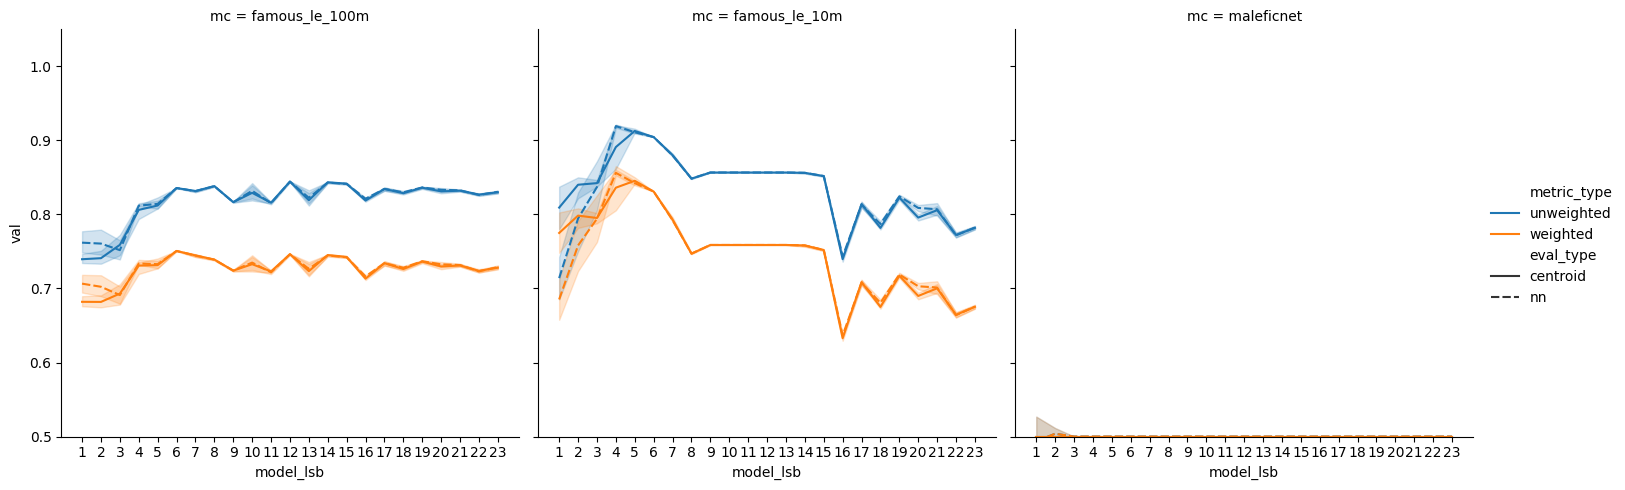

In [16]:
import seaborn as sns

g = sns.relplot(
    data=result_df,
    x='model_lsb',
    y='val',
    col='mc',
    hue='metric_type',
    style='eval_type',
    kind='line'
)

g.set(ylim=(0.5, 1.05))
lsbs = result_df['model_lsb'].unique()
g.set(xticks=lsbs)

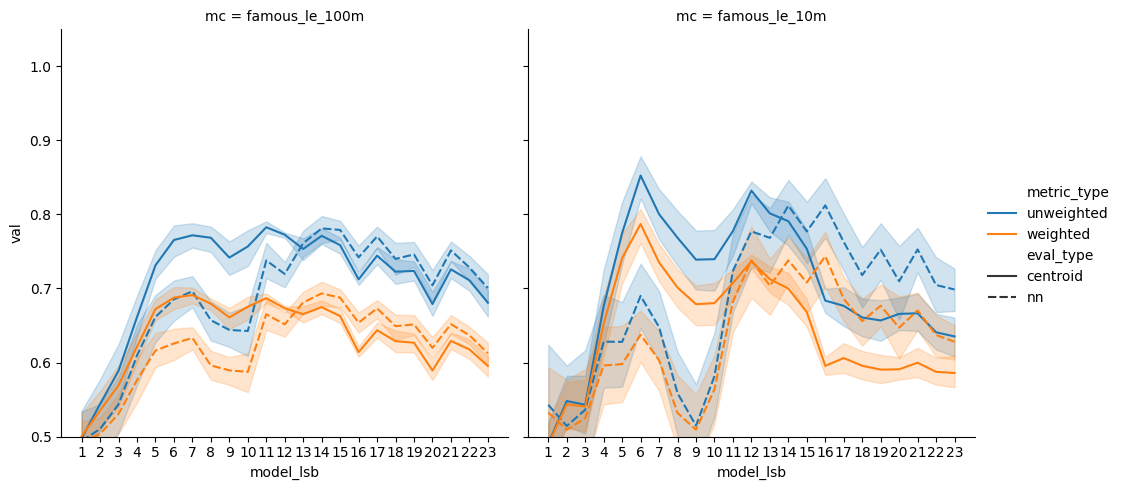

In [132]:
import seaborn as sns

g = sns.relplot(
    data=result_df,
    x='model_lsb',
    y='val',
    col='mc',
    hue='metric_type',
    style='eval_type',
    kind='line'
)

g.set(ylim=(0.5, 1.05))
lsbs = result_df['model_lsb'].unique()
g.set(xticks=lsbs)

# Maleficnet

In [29]:
from typing import Literal, Iterable
import pandas as pd

from model_xray.configs.enums import *

from model_xray.utils.script_utils import get_siamese_results_dataframe

def mask_df_by_df(df: pd.DataFrame, idx_cols: Iterable[str], df_idx: pd.DataFrame) -> pd.DataFrame:
    idx_tuples = df_idx[idx_cols].apply(tuple, axis=1)
    mask = df[idx_cols].apply(tuple, axis=1).isin(idx_tuples)
    return mask

mc_name:Literal['famous_le_10m', 'famous_le_100m']="famous_le_10m"
imtype:ImageType=ImageType.GRAYSCALE_FOURPART
imsize:int=100
mode:Literal['st', 'es', 'ub', 'none']='ub'

model_arch: Literal['osl_siamese_cnn', 'srnet'] = 'osl_siamese_cnn'
embed_payload_type: PayloadType = PayloadType.BINARY_FILE


df = get_siamese_results_dataframe(
    mc_name=mc_name,
    imtype=imtype,
    imsize=imsize,
    mode=mode,
    model_arch=model_arch,
    embed_payload_type=embed_payload_type
)

# df['mc'] = df['mc'].replace(
#     {
#         'maleficnet_benigns': 'maleficnet',
#         'maleficnet_mals': 'maleficnet'
#     }
# )

# df = df.groupby(['run num','mc', 'model_lsb']).apply(calc_metrics, include_groups=False,)
# df.reset_index(inplace=True)

# df.drop(columns=['weighted_metric_centroid', 'weighted_metric_nn'], inplace=True)

idx_cols = ['run num','model_lsb']

acc_threshold = 0.6

maleficnet_benign = (df['mc'] == 'maleficnet_benigns')

maleficnet_benign_over_nn = maleficnet_benign & (df['test_acc_nn'] > acc_threshold)
maleficnet_benign_over_nn_idxs = df[maleficnet_benign_over_nn][idx_cols]

maleficnet_benign_over_centroid = maleficnet_benign & (df['test_acc_centroid'] > acc_threshold)
maleficnet_benign_over_centroid_idxs = df[maleficnet_benign_over_centroid][idx_cols]

maleficnet_mals = (df['mc'] == 'maleficnet_mals')

maleficnet_mals_over_nn = maleficnet_mals & (df['test_acc_nn'] > acc_threshold)
maleficnet_mals_over_nn_idxs = df[maleficnet_mals_over_nn][idx_cols]

maleficnet_mals_over_centroid = maleficnet_mals & (df['test_acc_centroid'] > acc_threshold)
maleficnet_mals_over_centroid_idxs = df[maleficnet_mals_over_centroid][idx_cols]

maleficnet_benign_over_nn_mask = mask_df_by_df(df, idx_cols, maleficnet_benign_over_nn_idxs)
maleficnet_benign_over_centroid_mask = mask_df_by_df(df, idx_cols, maleficnet_benign_over_centroid_idxs)
maleficnet_mals_over_nn_mask = mask_df_by_df(df, idx_cols, maleficnet_mals_over_nn_idxs)
maleficnet_mals_over_centroid_mask = mask_df_by_df(df, idx_cols, maleficnet_mals_over_centroid_idxs)
                                                   
maleficnet_over_nn_mask = maleficnet_benign_over_nn_mask & maleficnet_mals_over_nn_mask
maleficnet_over_centroid_mask = maleficnet_benign_over_centroid_mask & maleficnet_mals_over_centroid_mask

maleficnet_over_mask = maleficnet_over_nn_mask | maleficnet_over_centroid_mask

df[maleficnet_over_mask][~((maleficnet_benign) | (maleficnet_mals))]

/tmp/ipykernel_1273201/3916900336.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[maleficnet_over_mask][~((maleficnet_benign) | (maleficnet_mals))]


,run num,mc,lsb,test_acc_centroid,test_acc_nn,model_lsb
100,2,famous_le_10m,0,1.000000,1.000000,1
101,2,famous_le_10m,1,0.000000,0.200000,1
102,2,famous_le_10m,2,0.000000,0.200000,1
103,2,famous_le_10m,3,0.400000,0.800000,1
104,2,famous_le_10m,4,0.800000,0.800000,1
...,...,...,...,...,...,...
56943,48,famous_le_100m,19,1.000000,1.000000,22
56944,48,famous_le_100m,20,1.000000,1.000000,22
56945,48,famous_le_100m,21,1.000000,1.000000,22
56946,48,famous_le_100m,22,1.000000,1.000000,22


# Whole process

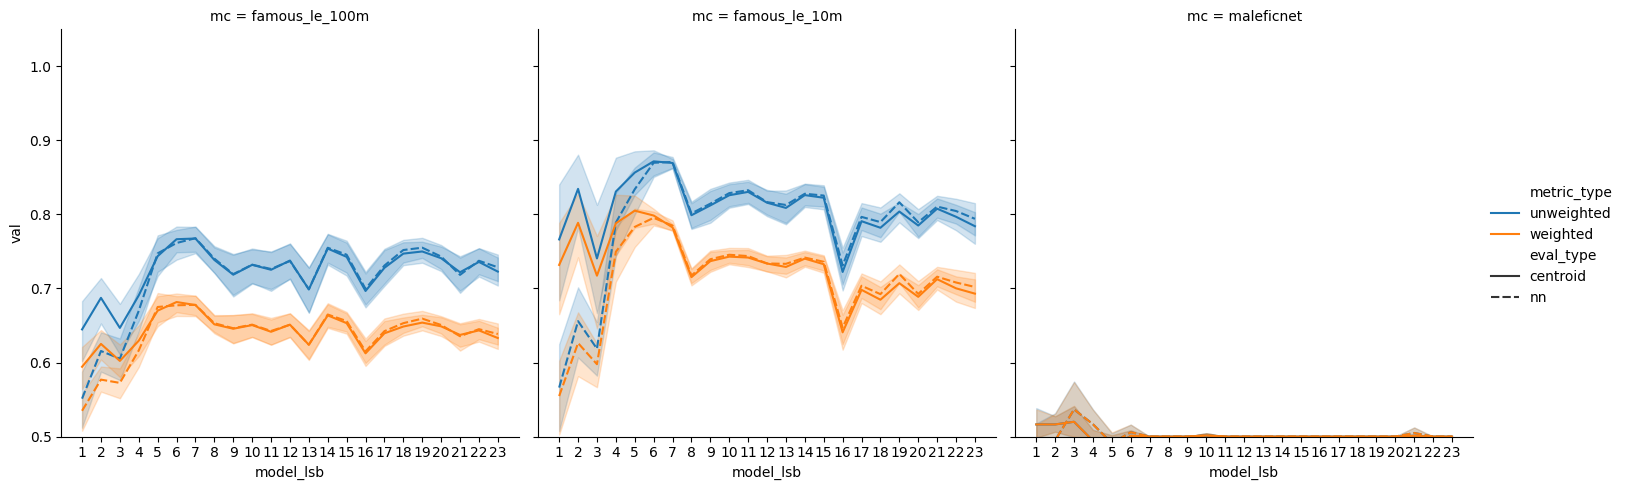

In [23]:
from typing import Literal
import pandas as pd

from model_xray.configs.enums import *

from model_xray.utils.script_utils import get_siamese_results_dataframe

def plot_siamese_results(
    mc_name:Literal['famous_le_10m', 'famous_le_100m']="famous_le_10m",
    imtype:ImageType=ImageType.GRAYSCALE_FOURPART,
    imsize:int=256,
    mode:Literal['st', 'es', 'ub', 'none']='ub',
    model_arch: Literal['osl_siamese_cnn', 'srnet'] = 'osl_siamese_cnn',
    embed_payload_type: PayloadType = PayloadType.BINARY_FILE,

    only_model_lsb:bool=False,
    include_maleficnet:bool=False,
    avg_across_runs:bool=False,
):
    df = get_siamese_results_dataframe(
        mc_name=mc_name,
        imtype=imtype,
        imsize=imsize,
        mode=mode,
        model_arch=model_arch,
        embed_payload_type=embed_payload_type
    )

    if only_model_lsb:
        df = df[(df['model_lsb'] == df['lsb']) | (df['lsb'] == 0)]

    if include_maleficnet:
        df['mc'] = df['mc'].replace(
            {
                'maleficnet_benigns': 'maleficnet',
                'maleficnet_mals': 'maleficnet'
            }
        )

    df = df[(df['mc']!='maleficnet_benigns') & (df['mc']!='maleficnet_mals')].groupby(['run num','mc', 'model_lsb']).apply(calc_metrics, include_groups=False,)

    df.reset_index(inplace=True)

    if avg_across_runs:
        df = df.groupby(['mc', 'model_lsb']).mean().reset_index().drop(columns=['run num'])

    # Melt the DataFrame
    melted_df = pd.melt(df, 
                        id_vars=['run num', 'mc', 'model_lsb'], 
                        var_name='variable', 
                        value_name='val')

    # Extract metric_type and eval_type from the 'variable' column
    melted_df[['metric_type', 'eval_type']] = melted_df['variable'].str.extract(r'(\w+)_(?:\w+)_(\w+)')

    # Drop the original 'variable' column
    melted_df = melted_df.drop('variable', axis=1)

    # Reorder the columns to match the desired output
    df = melted_df

    g = sns.relplot(
        data=df,
        x='model_lsb',
        y='val',
        col='mc',
        hue='metric_type',
        style='eval_type',
        kind='line'
    )

    g.set(ylim=(0.5, 1.05))
    lsbs = df['model_lsb'].unique()
    g.set(xticks=lsbs)

plot_siamese_results(
    mc_name='famous_le_10m',
    imsize=100,
    mode='es',
    model_arch='osl_siamese_cnn',
    
    include_maleficnet=True,
)